In [116]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from glob import glob
import random
import os

Calculates the AKMs and the mean/std on the coarse layers for the FIREX-AQ record. This is done because AKMs were not included in the NUCAPS files prior to v3.1. The variable names below will deviate from that in the operational NUCAPS EDR files.

In [2]:
# Select trace gas of interest
tg = 'o3'

# From NUCAPS data file
for_var_name = 'atrack*xtrack'
qf_var_name = 'qcmask'

pres_var_name = f'{tg}_func_pres' #*_func_pres
ak_var_name = f'{tg}_ave_kern' #*_ave_kern
pres_idx_var_name = f'{tg}_func_idx'

# From transformation matrix
f_var_name = f'{tg}_f_matrix' #*_f_matrix
fplus_var_name = f'{tg}_f_plus_matrix' #*_f_plus_matrix

In [3]:
# Nice names
nice_name = {
    'o3' : 'Ozone ($O_{3}$)',
    'ch4' : 'Methane ($CH_{4}$)',
    'h2o' : "Water Vapor ($H_{2}O$)",
    'co2' : 'Carbon Dioxide ($CO_{2}$)',
    'co' : 'Carbon Monoxide ($CO$)',
    'hno3' : 'Nitric Acid ($HNO_{3}$)',
    'air_temp' : 'Air Temperature'
}

In [4]:
# Read in FIREX-AQ record
files_all = glob('/mnt/firex-s3/2019/*/*/akfiles/'+'*.nc')
test_file = "/mnt/firex-s3/2019/07/01/retfiles/NUCAPS-sciEDR_n20_pm_s201907012350550_e201907012358530.nc"
test_ak_file = '/mnt/firex-s3/2019/07/01/akfiles/NUCAPS_sciAK_n20_am_s201907010031030_e201907010039010.nc'

In [179]:
xr.open_dataset(test_ak_file)

<xarray.Dataset>
Dimensions:                     (atrack*xtrack: 1800, air_temp_func_idx: 24,
                                 h2o_vap_func_idx: 12, co_func_idx: 10,
                                 co2_func_idx: 9, ch4_func_idx: 12,
                                 hno3_func_idx: 9, o3_func_idx: 10,
                                 pressure_layers: 100, air_temp_func_pres: 23,
                                 h2o_vap_func_pres: 11, co_func_pres: 9,
                                 co2_func_pres: 8, ch4_func_pres: 11,
                                 hno3_func_pres: 8, o3_func_pres: 9)
Coordinates:
  * air_temp_func_pres          (air_temp_func_pres) float32 0.714 ... 878.6
  * h2o_vap_func_pres           (h2o_vap_func_pres) float32 8.516 ... 971.2
  * co_func_pres                (co_func_pres) float32 1.488 41.11 ... 999.3
  * co2_func_pres               (co2_func_pres) float32 12.65 43.09 ... 706.6
  * ch4_func_pres               (ch4_func_pres) float32 1.683 24.85 ... 802.4
  * hno3_func_pres              (hno3_func_pres) float32 8.165 22.24 ... 459.7
  * o3_func_pres                (o3_func_pres) float32 2.916 33.96 ... 822.6
Dimensions without coordinates: atrack*xtrack, air_temp_func_idx,
                                h2o_vap_func_idx, co_func_idx, co2_func_idx,
                                ch4_func_idx, hno3_func_idx, o3_func_idx,
                                pressure_layers
Data variables: (12/32)
    latitude                    (atrack*xtrack) float32 ...
    longitude                   (atrack*xtrack) float32 ...
    qcmask                      (atrack*xtrack) float32 ...
    air_temp_ave_kern           (air_temp_func_idx, air_temp_func_idx, atrack*xtrack) float32 ...
    h2o_vap_ave_kern            (h2o_vap_func_idx, h2o_vap_func_idx, atrack*xtrack) float32 ...
    co_ave_kern                 (co_func_idx, co_func_idx, atrack*xtrack) float32 ...
    ...                          ...
    h2o_vap_bot_func_pres_eff   (atrack*xtrack) float32 ...
    co_bot_func_pres_eff        (atrack*xtrack) float32 ...
    co2_bot_func_pres_eff       (atrack*xtrack) float32 ...
    ch4_bot_func_pres_eff       (atrack*xtrack) float32 ...
    hno3_bot_func_pres_eff      (atrack*xtrack) float32 ...
    o3_bot_func_pres_eff        (atrack*xtrack) float32 ...

In [5]:
# Genderates the NUCAPS 100 level pressure layer and level grid from a sample file, saves it as csv
df_nucaps = xr.open_dataset(test_file)
pressure = df_nucaps.Pressure[0,:].values
effective_pressure = df_nucaps.Effective_Pressure[0,:].values

d = {'pressure': pressure, 'effective_pressure': effective_pressure}
df_press = pd.DataFrame(data=d)
df_press.to_csv('nucaps-pressure-grid.csv', index=False)

# Get the NUCAPS coarse pressure dims
df_ak_nucaps = xr.open_dataset(test_ak_file)
coarse_ndim = df_ak_nucaps[pres_idx_var_name].shape[0]

In [131]:
# For testing
rand_idx = random.sample(range(len(files_all)), 1000)

files = [files_all[i] for i in sorted(rand_idx)]

In [133]:
# Cycle through all files and extract the AK diagnonal, append to an array
# Note: in these AK files, there are 1800 FORs
dims = (len(files)*1800, coarse_ndim-1)
diag_tg = np.full(dims, np.nan)
start_pos = 0

for ii, file in enumerate(files):
    df = xr.open_dataset(file)

    if ii == 0:
        cris_fors = df[for_var_name].values
        p_tg = df[pres_var_name].values
        # pressure = df[pres_var_name]

    # There are some funky AK values (e.g. beyond the 0 to 1 range...), but perform QC using if statement
    ak_tg = [np.diag(df[ak_var_name].values[:-1,:-1, i]) for i in cris_fors if ((np.nansum(df[ak_var_name].values[:-1,:-1,i]) > 0) & (df[qf_var_name].values[i] == 0))]

    for j in np.arange(0, len(ak_tg)):
        diag_tg[start_pos+j,:] = ak_tg[j]

    start_pos = start_pos+j+1

In [134]:
# Calc mean/standard deviation
mean_ak = np.nanmean(diag_tg, axis=0)
std_ak = np.nanstd(diag_tg, axis=0)

# Save text data to file to avoid having to re-calculate
d = {'press': p_tg, 'mean': mean_ak, 'std': std_ak}
df_aks = pd.DataFrame(data=d)
df_aks.to_csv(f'firex-{tg}-aks.csv', index=False)

In [135]:
rand_idx = random.sample(range(diag_tg.shape[0]), 5000)

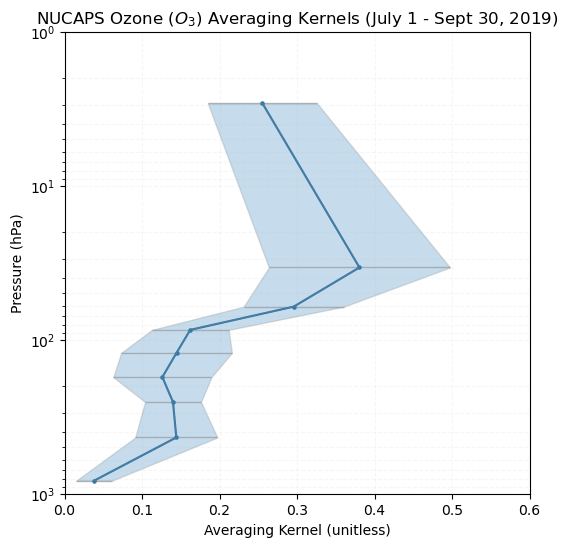

In [160]:
# Make a plot
fig, ax = plt.subplots(1,1, figsize=(6, 6))

ax.set_title(f"NUCAPS {nice_name[tg]} Averaging Kernels (July 1 - Sept 30, 2019)")

# for i in rand_idx:
#     ax.plot(diag_tg[i, :], p_tg, alpha=0.01, c='k')

ax.errorbar(mean_ak, p_tg, xerr=std_ak, c='grey', linewidth=1, alpha=0.5)
ax.fill_betweenx(p_tg, mean_ak-std_ak, mean_ak+std_ak, alpha=0.25, interpolate=True, edgecolor='grey')
ax.plot(mean_ak, p_tg, 'tab:blue')
ax.scatter(mean_ak, p_tg, c='tab:blue', s=5)

ax.set_ylim(1000,1)
ax.set_yscale('log')
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Averaging Kernel (unitless)")

ax.set_xlim(0,0.6)

# ax.set_xticks(np.arange(0, 0.6, 0.1))
# ax.set_yticks(np.arange(1000, 10, 100))
plt.grid(True,which="both", ls="--", alpha=0.1)
# plt.savefig('methane-ak.png')
# plt.close()
plt.show()

In [28]:
# Has ALL variables/trace gases
trans_m = xr.open_dataset("NUCAPS_transformation_matrix.nc")

In [29]:
# 100-lev AK Conversion example:
# https://github.com/resmaili/nucaps-f-matrix/blob/main/calc_nucaps_ak_allgases.pro (private repo)
# Calc F*F+
# G_temp = (TRANSPOSE(finea)#finv)#TRANSPOSE(finea)
# AK100_T(iobs,*,*) = (G_temp#ak_tmp)#TRANSPOSE(G_temp)
fplus = trans_m[fplus_var_name].values
fplus = np.ma.masked_invalid(fplus)
fplus = np.ma.masked_where(fplus >= 9.96e+36, fplus)

f = trans_m[f_var_name].values
f = np.ma.masked_invalid(f)
f = np.ma.masked_where(f >= 9.96e+36, f)

ffplus = np.ma.dot(f, fplus)

In [30]:
# df_aks = pd.read_csv(f'firex-{tg}-aks.csv')
mean_ak = df_aks['mean'].values
std_ak = df_aks['std'].values
p_tg = df_aks['press'].values

In [31]:
tg_ave_kern = np.zeros((coarse_ndim,coarse_ndim))
vals = mean_ak
np.fill_diagonal(tg_ave_kern, vals)

tg_ave_kern_std = np.zeros((coarse_ndim,coarse_ndim))
vals = std_ak
np.fill_diagonal(tg_ave_kern_std, vals)

In [33]:
# ak_t = tg_ave_kern #12x12

g_t_T = trans_m[fplus_var_name].values #12x100
g_t_T = np.ma.masked_invalid(g_t_T)

g_t = np.transpose(g_t_T) #100x12

lev100_tg = np.ma.dot(np.ma.dot(g_t, tg_ave_kern), g_t_T)
lev100_tg_std = np.ma.dot(np.ma.dot(g_t, tg_ave_kern_std), g_t_T)

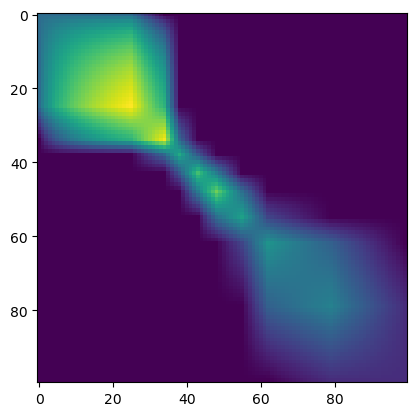

In [34]:
plt.figure()
plt.imshow(lev100_tg_std)
plt.show()

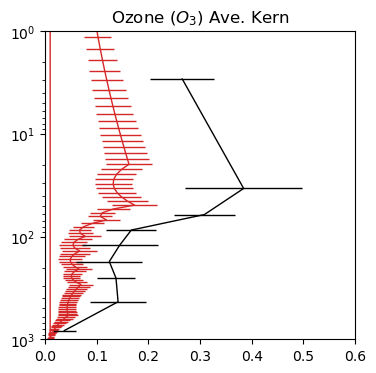

In [48]:
#AKs
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.set_title(f"{nice_name[tg]} Ave. Kern")
ax.errorbar(np.diag(lev100_tg).filled(), effective_pressure, xerr=np.diag(lev100_tg_std).filled(), c='tab:red', linewidth=1)
ax.errorbar(mean_ak, p_tg, xerr=std_ak, c='k', linewidth=1)

ax.set_ylim(1000,1)
ax.set_xlim(0,0.6)
ax.set_yscale('log')

# plt.savefig(f'{tg}-ak.png')
# plt.close()
plt.show()
